In [1]:
!pip  install  ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

# Mount Google Drive Account

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
drive.flush_and_unmount() # Unmount to reload drive contents

In [43]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Generate Random Images

* Generate 250 --> select 150 (deleting very similar frames to reduce annotation burden) --> reduce to 100 for testing purposes
* Note: include both images with and without torso to reduce false negatives:
* Visibility field: https://github.com/ultralytics/ultralytics/issues/4199
* Fully occluded torso: https://github.com/ultralytics/ultralytics/issues/7981
"If you want to include images with no annotations and ensure they are not filtered out, you might consider adding an empty annotation file for each such image. This way, the model understands these are intentional parts of the dataset."

In [ ]:
# Modified version of load_video_data.py to store into google drive folder

# Install dependencies
!pip install opencv-python-headless google-cloud-storage --quiet
!apt-get install ffmpeg -y


import os
import cv2
import numpy as np
import subprocess
import time
import random
import shutil
from google.cloud import storage
from pathlib import Path

class VideoDataLoader:
    def __init__(self, bucket_name="neonatal_video_data", timeout=30):
        self.bucket_name = bucket_name
        self.timeout = timeout

        if not shutil.which('ffmpeg'):
            raise RuntimeError("ffmpeg not found. Please install ffmpeg first.")

        self.storage_client = storage.Client.create_anonymous_client()
        self.bucket = self.storage_client.bucket(bucket_name)
        print("Successfully connected to public GCS bucket")

    def list_videos(self, prefix="videos/"):
        blobs = list(self.bucket.list_blobs(prefix=prefix))
        return [blob for blob in blobs if blob.name.lower().endswith(('.mp4', '.avi', '.mov'))]

    def extract_random_frame_from_blob(self, blob):
        print(f"\nProcessing video: {blob.name}")
        start_time = time.time()

        probe_cmd = [
            'ffprobe', '-v', 'error', '-show_entries', 'format=duration',
            '-of', 'default=noprint_wrappers=1:nokey=1',
            f'https://storage.googleapis.com/{self.bucket_name}/{blob.name}'
        ]
        duration = float(subprocess.check_output(probe_cmd).decode().strip())
        rand_time = random.uniform(0, min(duration, 30))

        frame_cmd = [
            'ffmpeg', '-ss', str(rand_time),
            '-i', f'https://storage.googleapis.com/{self.bucket_name}/{blob.name}',
            '-frames:v', '1', '-f', 'image2pipe',
            '-pix_fmt', 'bgr24', '-vcodec', 'rawvideo', '-'
        ]
        frame_data = subprocess.check_output(frame_cmd, timeout=self.timeout)
        frame = np.frombuffer(frame_data, np.uint8)

        size_cmd = [
            'ffprobe', '-v', 'error', '-select_streams', 'v:0',
            '-show_entries', 'stream=width,height',
            '-of', 'csv=s=x:p=0',
            f'https://storage.googleapis.com/{self.bucket_name}/{blob.name}'
        ]
        dimensions = subprocess.check_output(size_cmd).decode().strip()
        width, height = map(int, dimensions.split('x'))
        frame = frame.reshape((height, width, 3))

        print(f"Frame extracted in {time.time() - start_time:.1f}s")
        return frame

    def load_random_frames(self, num_frames=5):
        videos = self.list_videos()
        if not videos:
            raise ValueError("No videos found in bucket.")

        frames, sources = [], []
        attempts = 0
        while len(frames) < num_frames and attempts < num_frames * 2:
            attempts += 1
            video_blob = random.choice(videos)
            try:
                frame = self.extract_random_frame_from_blob(video_blob)
                frames.append(frame)
                sources.append(video_blob.name)
                print(f"Extracted frame {len(frames)} / {num_frames}")
            except Exception as e:
                print(f"Failed on {video_blob.name}: {e}")
                continue

        if not frames:
            raise ValueError("No frames could be extracted.")
        return frames, sources

def run_loader(num_frames=5, output_dir="/content/drive/MyDrive/frames_output", seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)  # if needed

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    else:
        print(f"Using existing directory: {output_dir}")

    loader = VideoDataLoader()
    videos = loader.list_videos()

    if not videos:
        raise ValueError("No videos found in the bucket.")

    saved = 0
    attempts = 0
    max_attempts = num_frames * 2

    while saved < num_frames and attempts < max_attempts:
        attempts += 1
        video_blob = random.choice(videos)
        try:
            frame = loader.extract_random_frame_from_blob(video_blob)
            video_name = Path(video_blob.name).stem
            filepath = Path(output_dir) / f"{video_name}_frame_{saved}.jpg"
            print(f"Saving frame {saved+1}/{num_frames} to {filepath}")
            cv2.imwrite(str(filepath), frame)
            saved += 1
        except Exception as e:
            print(f"Failed on {video_blob.name}: {e}")
            continue

    if saved == 0:
        raise ValueError("Failed to save any frames.")
    print(f"\nSaved {saved} frames to: {output_dir}")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
images_output_dir = "/content/drive/MyDrive/6.7930/Images4"
run_loader(num_frames=250, output_dir=images_output_dir, seed=42) # added seed for reproducibility

Created directory: /content/drive/MyDrive/6.7930/Images4
Successfully connected to public GCS bucket

Processing video: videos/1.22.25_sc10.mp4
Frame extracted in 2.3s
Saving frame 1/250 to /content/drive/MyDrive/6.7930/Images4/1.22.25_sc10_frame_0.jpg

Processing video: videos/2.24.25_sc2.mp4
Frame extracted in 1.8s
Saving frame 2/250 to /content/drive/MyDrive/6.7930/Images4/2.24.25_sc2_frame_1.jpg

Processing video: videos/1.22.25_sc6.mp4
Frame extracted in 1.9s
Saving frame 3/250 to /content/drive/MyDrive/6.7930/Images4/1.22.25_sc6_frame_2.jpg

Processing video: videos/2.6.25_sc6.mp4
Frame extracted in 2.1s
Saving frame 4/250 to /content/drive/MyDrive/6.7930/Images4/2.6.25_sc6_frame_3.jpg

Processing video: videos/2.28.25_sc3.mp4
Frame extracted in 1.8s
Saving frame 5/250 to /content/drive/MyDrive/6.7930/Images4/2.28.25_sc3_frame_4.jpg

Processing video: videos/1.22.25_sc5.mp4
Frame extracted in 1.8s
Saving frame 6/250 to /content/drive/MyDrive/6.7930/Images4/1.22.25_sc5_frame_5.jpg

In [ ]:
import os
import random
import shutil

def copy_random_images_from_drive(src_folder, dest_folder, num_images=10, seed=42):
    """
    Randomly selects images from a source folder in Google Drive and copies them to a new folder.

    Args:
        src_folder (str): Full path to source folder (e.g., "/content/drive/MyDrive/images")
        dest_folder (str): Destination folder to copy images to
        num_images (int): Number of images to randomly select
        seed (int): Random seed for reproducibility
    """
    os.makedirs(dest_folder, exist_ok=True)
    random.seed(seed)

    # Only include image files
    image_extensions = ('.jpg', '.jpeg', '.png')
    all_images = [f for f in os.listdir(src_folder) if f.lower().endswith(image_extensions)]

    if len(all_images) == 0:
        raise ValueError(f"No images found in {src_folder}")

    selected = random.sample(all_images, min(num_images, len(all_images)))

    for img in selected:
        src_path = os.path.join(src_folder, img)
        dst_path = os.path.join(dest_folder, img)
        shutil.copy2(src_path, dst_path)

    print(f"✅ Copied {len(selected)} image(s) to: {dest_folder}")


In [ ]:
copy_random_images_from_drive(
    src_folder="/content/drive/MyDrive/6.7930/Image_250_seed42_selected",
    dest_folder="/content/drive/MyDrive/6.7930/Image_250_seed42_selected_100_subset",
    num_images=100
)

✅ Copied 100 image(s) to: /content/drive/MyDrive/6.7930/Image_250_seed42_selected_100_subset


In [ ]:
import os
import shutil

def rename_and_move_images(src_folder, dest_folder, prefix_to_remove="Copy of "):
    """
    Moves and renames images from src_folder to dest_folder by removing a specific prefix from filenames.

    Args:
        src_folder (str): Source folder containing the images
        dest_folder (str): Destination folder for renamed images
        prefix_to_remove (str): Prefix to strip from filenames (default = "Copy of ")
    """
    os.makedirs(dest_folder, exist_ok=True)

    image_extensions = ('.jpg', '.jpeg', '.png')

    moved = 0
    for filename in os.listdir(src_folder):
        if filename.lower().endswith(image_extensions) and filename.startswith(prefix_to_remove):
            new_name = filename[len(prefix_to_remove):]  # strip the prefix
            src_path = os.path.join(src_folder, filename)
            dst_path = os.path.join(dest_folder, new_name)
            shutil.copy2(src_path, dst_path)
            moved += 1

    print(f"✅ Moved and renamed {moved} image(s) to: {dest_folder}")


In [ ]:
rename_and_move_images(
    src_folder="/content/drive/MyDrive/6.7930/Image_250_seed42_selected_100_subset",
    dest_folder="/content/drive/MyDrive/6.7930/Image_250_seed42_selected_100_subset_renamed"
)

✅ Moved and renamed 100 image(s) to: /content/drive/MyDrive/6.7930/Image_250_seed42_selected_100_subset_renamed




---



# Setup File Structure
```
datasets/
└── torso/ <-- (class label)
    ├── images/
    │   ├── train/
    │   └── val/
    ├── labels/
    │   ├── train/
    │   └── val/
    └── torso.yaml
```

In [3]:
import os
import yaml

def setup_yolo_pose_dataset(drive_path="/content/drive/MyDrive",
                            dataset_name="torso",
                            num_keypoints=4,
                            class_name="torso",
                            keypoint_order=["left shoulder", "right shoulder", "left hip", "right hip"]):
    """
    Creates a folder structure and dataset YAML config for YOLOv8 pose training in Google Drive.
    """

    base_path = os.path.join(drive_path, dataset_name)

    # Folder structure
    image_train = os.path.join(base_path, "images/train")
    image_val = os.path.join(base_path, "images/val")
    label_train = os.path.join(base_path, "labels/train")
    label_val = os.path.join(base_path, "labels/val")

    os.makedirs(image_train, exist_ok=True)
    os.makedirs(image_val, exist_ok=True)
    os.makedirs(label_train, exist_ok=True)
    os.makedirs(label_val, exist_ok=True)

    # Class index
    class_dict = {0: class_name}

    def infer_flip_idx(kp_order):
        flip = []
        for i, kp in enumerate(kp_order):
            if "left" in kp:
                try: flip.append(kp_order.index(kp.replace("left", "right")))
                except: flip.append(i)
            elif "right" in kp:
                try: flip.append(kp_order.index(kp.replace("right", "left")))
                except: flip.append(i)
            else:
                flip.append(i)
        return flip

    flip_idx = infer_flip_idx(keypoint_order)

    # Inline list formatting for YAML
    class InlineList(list): pass
    def represent_inline_list(dumper, data):
        return dumper.represent_sequence('tag:yaml.org,2002:seq', data, flow_style=True)
    yaml.add_representer(InlineList, represent_inline_list)

    yaml_dict = {
        "path": base_path,
        "train": "images/train",
        "val": "images/val",
        "kpt_shape": InlineList([num_keypoints, 3]),
        "flip_idx": InlineList(flip_idx),
        "names": class_dict
    }

    yaml_path = os.path.join(base_path, f"{dataset_name}.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(yaml_dict, f, sort_keys=False)

    print(f"✅ Dataset folder and YAML created at: {base_path}")
    print(f"🧾 YAML config: {yaml_path}")


# Split images into train/val

In [4]:
import random
import shutil

def split_and_copy_images(image_folder, dest_image_folder, val_ratio=0.2):
    all_images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png'))]
    random.shuffle(all_images)

    split_idx = int(len(all_images) * (1 - val_ratio))
    train_imgs = all_images[:split_idx]
    val_imgs = all_images[split_idx:]

    for f in train_imgs:
        shutil.copy(os.path.join(image_folder, f), os.path.join(dest_image_folder, "train", f))
    for f in val_imgs:
        shutil.copy(os.path.join(image_folder, f), os.path.join(dest_image_folder, "val", f))

    return train_imgs, val_imgs

# Convert CSV annotation format to Yolov8 for pose estimation

(Label images with [left shoulder, right shoulder, left hip, right hip]. Note that left and right are with respective to the mannequin not the viewer)

In [5]:
import os
import pandas as pd
from collections import defaultdict

def convert_makesense_csv_to_yolo_labels(csv_path, output_dir, image_list, keypoint_order):
    df = pd.read_csv(csv_path, header=None)
    df.columns = ["keypoint", "x", "y", "filename", "img_width", "img_height"]

    ordered_kps = keypoint_order
    grouped = defaultdict(list)

    for _, row in df.iterrows():
        fname = row["filename"]
        kp_label = row["keypoint"].strip().lower()
        grouped[fname].append({
            "keypoint": kp_label,
            "x": row["x"] / row["img_width"],
            "y": row["y"] / row["img_height"],
            "vis": 1  # updated to use 1 for visible
        })

    os.makedirs(output_dir, exist_ok=True)

    for fname in image_list:
        kps = grouped.get(fname, [])
        if not kps:
            # No annotation → write empty .txt
            label_path = os.path.join(output_dir, os.path.splitext(fname)[0] + ".txt")
            open(label_path, "w").close()
            continue

        # build keypoint dictionary
        kp_dict = {kp["keypoint"]: kp for kp in kps}
        if not all(k in kp_dict for k in ordered_kps):
            # still create an empty .txt if annotation is partial
            label_path = os.path.join(output_dir, os.path.splitext(fname)[0] + ".txt")
            open(label_path, "w").close()
            continue

        # format full label line
        keypoints_flat = []
        x_vals, y_vals = [], []
        for k in ordered_kps:
            kp = kp_dict[k]
            keypoints_flat.extend([kp["x"], kp["y"], kp["vis"]])
            x_vals.append(kp["x"])
            y_vals.append(kp["y"])

        x_center = (min(x_vals) + max(x_vals)) / 2
        y_center = (min(y_vals) + max(y_vals)) / 2
        bbox_w = max(x_vals) - min(x_vals)
        bbox_h = max(y_vals) - min(y_vals)

        label_line = f"0 {x_center:.6f} {y_center:.6f} {bbox_w:.6f} {bbox_h:.6f} " + \
                     " ".join(f"{v:.6f}" if i % 3 != 2 else f"{int(v)}"
                              for i, v in enumerate(keypoints_flat))

        label_path = os.path.join(output_dir, os.path.splitext(fname)[0] + ".txt")
        with open(label_path, "w") as f:
            f.write(label_line + "\n")


In [6]:
import cv2
import matplotlib.pyplot as plt
import os

def visualize_yolo_pose_annotation(base_path, split="train", image_filename="frame_00001.png"):
    image_path = os.path.join(base_path, "images", split, image_filename)
    label_path = os.path.join(base_path, "labels", split, os.path.splitext(image_filename)[0] + ".txt")

    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Image not found: {image_path}")
        return

    h, w = image.shape[:2]

    if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
        with open(label_path, "r") as f:
            line = f.readline().strip().split()
            if len(line) >= 5:
                class_id = int(line[0])
                x_center, y_center, box_w, box_h = map(float, line[1:5])
                keypoints = list(map(float, line[5:]))

                # Draw bounding box
                x1 = int((x_center - box_w / 2) * w)
                y1 = int((y_center - box_h / 2) * h)
                x2 = int((x_center + box_w / 2) * w)
                y2 = int((y_center + box_h / 2) * h)
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

                # Draw keypoints
                kp_labels = ["left shoulder", "right shoulder", "left hip", "right hip"]
                for i in range(4):
                    x = int(keypoints[i * 3] * w)
                    y = int(keypoints[i * 3 + 1] * h)
                    vis = int(keypoints[i * 3 + 2])
                    if vis > 0:
                        cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
                        cv2.putText(image, kp_labels[i], (x + 5, y - 5),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Show image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image_filename)
    plt.show()


In [8]:
import os

def doesPathExists(path):
  if os.path.exists(path):
      print("✅ Path exists!")
  else:
      print("❌ Path does not exist!")

doesPathExists(path = "/content/drive/MyDrive/6.7930/Images_100")
doesPathExists(path = "/content/drive/MyDrive/6.7930/Images_100.csv")

✅ Path exists!
✅ Path exists!


In [9]:
drive_path = "/content/drive/My Drive/6.7930"
dataset_name = "torso_dataset"
image_folder = os.path.join(drive_path, "Images_100")
csv_path = os.path.join(drive_path, "Images_100.csv")
keypoint_order = ["left shoulder", "right shoulder", "left hip", "right hip"]

# Step 1: Set up folders + YAML
setup_yolo_pose_dataset(
    drive_path=drive_path,
    dataset_name=dataset_name,
    num_keypoints=4,
    class_name="torso",
    keypoint_order=keypoint_order
)

base_path = os.path.join(drive_path, dataset_name)

# Step 2: Copy and split images into folders
train_imgs, val_imgs = split_and_copy_images(image_folder, os.path.join(base_path, "images"))

# Step 3: Convert CSV to YOLO labels for each split
convert_makesense_csv_to_yolo_labels(csv_path, os.path.join(base_path, "labels/train"), train_imgs, keypoint_order)
convert_makesense_csv_to_yolo_labels(csv_path, os.path.join(base_path, "labels/val"), val_imgs, keypoint_order)


✅ Dataset folder and YAML created at: /content/drive/My Drive/6.7930/torso_dataset
🧾 YAML config: /content/drive/My Drive/6.7930/torso_dataset/torso_dataset.yaml


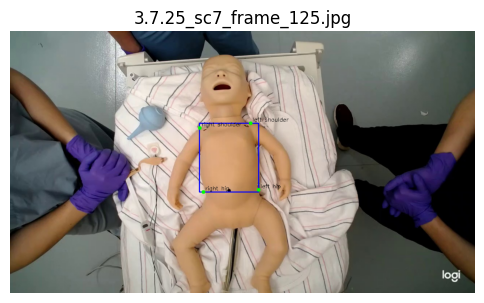

In [10]:
visualize_yolo_pose_annotation(
    base_path=base_path,
    split="train",
    image_filename="3.7.25_sc7_frame_125.jpg"
)

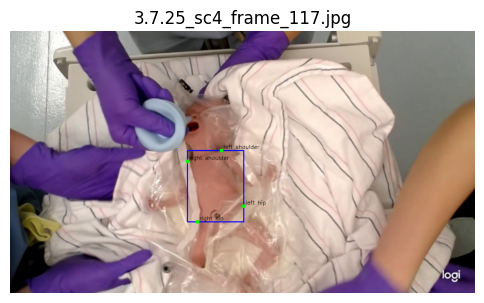

In [11]:
visualize_yolo_pose_annotation(
    base_path=base_path,
    split="train",
    image_filename="3.7.25_sc4_frame_117.jpg"
)

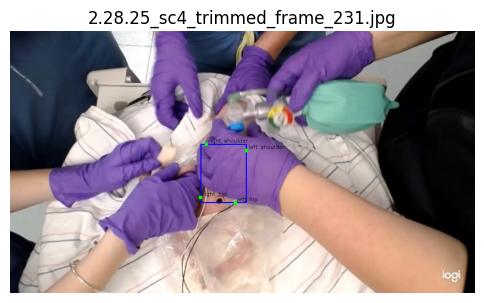

In [12]:
visualize_yolo_pose_annotation(
    base_path=base_path,
    split="train",
    image_filename="2.28.25_sc4_trimmed_frame_231.jpg"
)

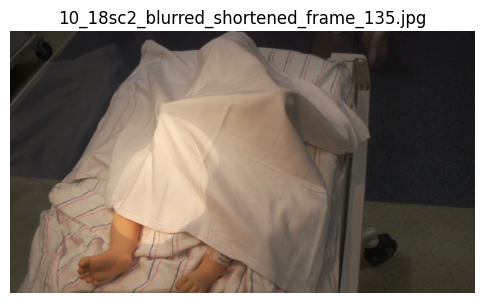

In [13]:
visualize_yolo_pose_annotation(
    base_path=base_path,
    split="train",
    image_filename="10_18sc2_blurred_shortened_frame_135.jpg"
)



---






# Model Training

In [15]:
import torch
if torch.cuda.is_available():
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU not available. Training will use CPU.")

✅ GPU available: NVIDIA A100-SXM4-40GB


In [16]:
model = YOLO('yolov8n-pose.pt'); # Pretrained weights (https://docs.ultralytics.com/tasks/pose/)

yaml_path = os.path.join(base_path, "torso_dataset.yaml")

# === Training Hyperparameters ===
EPOCH_NUM = 100
IMG_SIZE = 640               # All images resized to 640x640 during training/inference
BATCH_SIZE = 8                # 10 gradient updates per epoch (80 ÷ 8) (100 Images, 80/20 split)
DEVICE = "0"                 # GPU 0 (use "cpu" if no GPU)
INIT_LR = 0.001
OPTIMIZER = "AdamW"
RUN_NAME = "torso_pose"
PROJECT_DIR = os.path.join(drive_path, "training_logs", "torso_pose")

# === Run Training ===
model.train(
    data=yaml_path,
    epochs=EPOCH_NUM,
    imgsz=IMG_SIZE,             # Image resolution (square)
    batch=BATCH_SIZE,
    device=DEVICE,
    lr0=INIT_LR,
    optimizer=OPTIMIZER,
    name=RUN_NAME,              # Run name (used in save dir)
    project=PROJECT_DIR,        # Directory to save model logs/weights

    # === Additional Training Controls ===
    patience=20,                # Early stopping patience (epochs without improvement)
    verbose=True,               # Print progress bar + training logs
    seed=42,                    # Random seed for reproducibility
    val=True,                   # Run validation after every epoch
    save=True,                  # Save best and last model
    save_period=1,              # Save checkpoint every N epochs

    # === Learning Warm-up ===
    warmup_epochs=3,            # Warmup epochs to stabilize early training
    dropout=0.1,                # Dropout regularization to reduce overfitting

    # === Pose-Specific Options ===
    overlap_mask=True,          # Improve keypoint accuracy when multiple objects overlapping

    # === Data Augmentation (light) ===
    scale=0.3,                  # Random scale factor range (±30%)
    translate=0.1,              # Random translation (±10%)
    fliplr=0.5,                 # Random left-right flip (50%)

)

100%|██████████| 6.52M/6.52M [00:00<00:00, 79.3MB/s]


Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=/content/drive/My Drive/6.7930/torso_dataset/torso_dataset.yaml, epochs=100, time=None, patience=20, batch=8, imgsz=640, save=True, save_period=1, cache=False, device=0, workers=8, project=/content/drive/My Drive/6.7930/training_logs/torso_pose, name=torso_pose, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_t

100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[4, 3]

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.0MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/My Drive/6.7930/torso_dataset/labels/train... 80 images, 5 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 296.11it/s]


train: New cache created: /content/drive/My Drive/6.7930/torso_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/My Drive/6.7930/torso_dataset/labels/val... 20 images, 1 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 177.28it/s]

val: New cache created: /content/drive/My Drive/6.7930/torso_dataset/labels/val.cache


Plotting labels to /content/drive/My Drive/6.7930/training_logs/torso_pose/torso_pose/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/My Drive/6.7930/training_logs/torso_pose/torso_pose
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/100       1.2G      2.769      7.488     0.6893      8.548      3.168         16        640: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         20         19    0.00303      0.947     0.0141     0.0059   0.000168     0.0526   0.000102   1.02e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.22G      1.884      4.897     0.5845      2.476      2.102         14        640: 100%|██████████| 10/10 [00:00<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.86it/s]

                   all         20         19       0.38      0.421      0.345      0.151      0.428      0.474      0.361      0.124



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.23G      1.365      2.755     0.5544      1.637      1.622         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


                   all         20         19      0.438      0.526      0.478      0.296      0.417      0.526      0.484      0.211

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.25G      1.105       1.93     0.5732      1.087      1.372         17        640: 100%|██████████| 10/10 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]

                   all         20         19      0.928      0.684      0.803       0.57      0.928      0.684      0.834      0.454



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.27G      1.107      1.647     0.5173      1.036      1.372         16        640: 100%|██████████| 10/10 [00:00<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.79it/s]

                   all         20         19      0.805      0.872      0.894      0.663      0.854      0.923      0.946      0.566



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.29G      1.107      1.586     0.4813     0.9253      1.317         11        640: 100%|██████████| 10/10 [00:00<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.12it/s]

                   all         20         19          1      0.838      0.911      0.659          1      0.838      0.946      0.688



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/100       1.3G     0.9307      1.362     0.4872     0.8064      1.194         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.24it/s]

                   all         20         19      0.996      0.842      0.931      0.696      0.947      0.941      0.986      0.694



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.32G     0.9449      1.277     0.5132     0.9279      1.165         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.57it/s]

                   all         20         19      0.996      0.842      0.931      0.717      0.849          1      0.975      0.834



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.34G     0.8744      1.304     0.5451     0.7572      1.068         13        640: 100%|██████████| 10/10 [00:00<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.37it/s]

                   all         20         19          1      0.886      0.941      0.741          1      0.886      0.978      0.826



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.36G     0.8406      1.148     0.4699     0.6858      1.027         18        640: 100%|██████████| 10/10 [00:00<00:00, 11.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.22it/s]

                   all         20         19          1      0.945      0.946      0.766          1      0.945       0.97      0.808



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.37G     0.7892      1.117     0.4757     0.6545     0.9965         13        640: 100%|██████████| 10/10 [00:00<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.25it/s]

                   all         20         19      0.998      0.947      0.946      0.753      0.998      0.947      0.961      0.859



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.39G     0.9087       1.15     0.5003     0.6639      1.056         13        640: 100%|██████████| 10/10 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.58it/s]

                   all         20         19          1      0.944      0.947      0.768          1      0.944      0.953      0.826



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.41G     0.9404      1.288     0.5265     0.7372       1.08          7        640: 100%|██████████| 10/10 [00:00<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.93it/s]


                   all         20         19      0.999      0.947      0.956      0.721      0.999      0.947      0.956      0.856

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.43G     0.7419     0.8227     0.4295     0.5418     0.9586         16        640: 100%|██████████| 10/10 [00:00<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.53it/s]

                   all         20         19      0.996      0.947      0.957      0.759      0.996      0.947      0.957      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.44G     0.8649      1.045     0.4596     0.6009     0.9981         14        640: 100%|██████████| 10/10 [00:00<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.15it/s]

                   all         20         19      0.995      0.947      0.948      0.801      0.995      0.947      0.948      0.887



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.46G     0.8345     0.9573     0.4682     0.5694     0.9947         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.60it/s]

                   all         20         19      0.997      0.947      0.954      0.793      0.997      0.947      0.954      0.896



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.48G     0.7896     0.8986     0.4287     0.5362     0.9596         16        640: 100%|██████████| 10/10 [00:00<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.04it/s]

                   all         20         19      0.997      0.947      0.953      0.786      0.997      0.947      0.953      0.917



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/100       1.5G     0.7912     0.9221      0.497     0.5219     0.9668         14        640: 100%|██████████| 10/10 [00:00<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.78it/s]

                   all         20         19      0.997      0.947      0.951      0.763      0.997      0.947      0.951      0.883



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.51G     0.7868     0.8143     0.4309     0.5009     0.9653         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.66it/s]

                   all         20         19      0.997      0.947      0.968       0.82      0.997      0.947      0.968      0.898



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.53G     0.7123     0.7656     0.4568     0.4912     0.9385         19        640: 100%|██████████| 10/10 [00:00<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.09it/s]

                   all         20         19      0.997      0.947      0.986      0.822      0.997      0.947      0.986      0.932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.55G     0.6697     0.6183      0.406     0.4482     0.8943         13        640: 100%|██████████| 10/10 [00:00<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.11it/s]

                   all         20         19          1      0.997      0.995      0.813          1      0.997      0.995      0.943



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.57G     0.7838     0.7933     0.4805     0.5128     0.9572         13        640: 100%|██████████| 10/10 [00:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.57it/s]

                   all         20         19          1      0.998      0.995      0.786          1      0.998      0.995      0.942



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.58G     0.7316     0.7894     0.4415     0.4877     0.9557         16        640: 100%|██████████| 10/10 [00:00<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.68it/s]

                   all         20         19          1      0.997      0.995      0.783          1      0.997      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/100       1.6G     0.7349     0.7414     0.4744     0.5435     0.9473         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]

                   all         20         19          1      0.997      0.995       0.79          1      0.997      0.995      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.62G     0.6946     0.7514     0.4158      0.479      0.913         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]

                   all         20         19          1          1      0.995      0.796          1          1      0.995      0.964



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.63G     0.6892     0.4801     0.4088     0.4406     0.9068         17        640: 100%|██████████| 10/10 [00:00<00:00, 11.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.05it/s]

                   all         20         19      0.997          1      0.995      0.824      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.65G     0.6548     0.5218     0.4237     0.4408     0.9238         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.81it/s]

                   all         20         19      0.997          1      0.995      0.821      0.997          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.67G     0.6993     0.5204     0.4301     0.4557     0.9313         10        640: 100%|██████████| 10/10 [00:00<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.77it/s]

                   all         20         19      0.996          1      0.995      0.825      0.996          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.69G     0.6368     0.6379     0.3574     0.4375     0.9056         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.59it/s]

                   all         20         19      0.995          1      0.995      0.831      0.995          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.71G     0.7017     0.6257     0.4345     0.4515     0.9074         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.78it/s]

                   all         20         19      0.997          1      0.995       0.79      0.997          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.72G     0.6855     0.5308     0.4369     0.4484      0.904         16        640: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.00it/s]

                   all         20         19      0.998          1      0.995      0.793      0.998          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.74G     0.7372     0.7021     0.4667     0.4929     0.9432         14        640: 100%|██████████| 10/10 [00:00<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]

                   all         20         19      0.999          1      0.995      0.807      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.76G     0.6925     0.5475     0.4228     0.4484      0.909         13        640: 100%|██████████| 10/10 [00:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.80it/s]

                   all         20         19          1      0.996      0.995      0.793          1      0.996      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.78G     0.7061     0.5743     0.4648     0.4626     0.9225         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.38it/s]

                   all         20         19      0.997      0.947      0.993      0.811      0.997      0.947      0.993      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.79G     0.6604     0.5998     0.4217      0.451      0.898         21        640: 100%|██████████| 10/10 [00:00<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.86it/s]

                   all         20         19      0.997      0.947      0.993      0.805      0.997      0.947      0.993      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.81G     0.6602     0.5254      0.382     0.4252      0.907         16        640: 100%|██████████| 10/10 [00:00<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.94it/s]

                   all         20         19      0.997      0.947      0.993      0.835      0.997      0.947      0.993      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.83G     0.6322      0.532     0.4739     0.4454     0.9163         15        640: 100%|██████████| 10/10 [00:00<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.51it/s]

                   all         20         19      0.997      0.947      0.993      0.838      0.997      0.947      0.993      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.84G       0.61      0.433     0.3883     0.4158     0.8871         10        640: 100%|██████████| 10/10 [00:00<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.52it/s]

                   all         20         19          1      0.994      0.995       0.82          1      0.994      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.86G     0.6024      0.446     0.4064     0.4143     0.9016         15        640: 100%|██████████| 10/10 [00:00<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.48it/s]

                   all         20         19          1      0.996      0.995      0.841          1      0.996      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.88G     0.6395     0.5537     0.3803     0.4042     0.8861         10        640: 100%|██████████| 10/10 [00:00<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

                   all         20         19          1      0.998      0.995      0.844          1      0.998      0.995      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/100       1.9G     0.5881     0.4426     0.4628       0.41     0.8805          8        640: 100%|██████████| 10/10 [00:00<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.84it/s]

                   all         20         19          1          1      0.995      0.827          1          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.92G      0.624     0.5538     0.3709      0.397     0.9032         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]


                   all         20         19      0.996          1      0.995      0.843      0.996          1      0.995      0.976

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.93G     0.5393     0.4148     0.3993     0.3537     0.8783         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.95it/s]

                   all         20         19      0.996          1      0.995      0.824      0.996          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.95G      0.558     0.4059     0.4347     0.3734     0.8632         11        640: 100%|██████████| 10/10 [00:00<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.60it/s]

                   all         20         19      0.996          1      0.995      0.834      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.97G     0.5894     0.4934     0.4209     0.3964     0.8793         14        640: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.09it/s]

                   all         20         19      0.996          1      0.995      0.828      0.996          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.99G     0.5897     0.4666     0.4138     0.3762     0.8822         15        640: 100%|██████████| 10/10 [00:00<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]

                   all         20         19      0.997          1      0.995      0.831      0.997          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/100         2G     0.5742     0.4308      0.407     0.3717     0.8699         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.24it/s]

                   all         20         19      0.997          1      0.995      0.832      0.997          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.02G      0.614     0.3762     0.4219     0.3815     0.8841         13        640: 100%|██████████| 10/10 [00:00<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.46it/s]

                   all         20         19      0.997          1      0.995      0.838      0.997          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.04G     0.5803     0.3799     0.3882     0.3885     0.8793         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.86it/s]

                   all         20         19      0.997          1      0.995      0.833      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.06G     0.5776     0.3828     0.4326     0.3679     0.8767          9        640: 100%|██████████| 10/10 [00:00<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]

                   all         20         19      0.997          1      0.995      0.859      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.07G     0.6057     0.3882     0.4479     0.3877      0.896         17        640: 100%|██████████| 10/10 [00:00<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.16it/s]

                   all         20         19      0.997          1      0.995      0.862      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.09G     0.5807      0.404     0.4304     0.3717     0.8923         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]

                   all         20         19      0.997          1      0.995      0.885      0.997          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.11G     0.5448     0.3249      0.349     0.3632     0.8659         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.29it/s]

                   all         20         19      0.997          1      0.995      0.868      0.997          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.12G     0.5278     0.4312     0.4109     0.3524     0.8576         17        640: 100%|██████████| 10/10 [00:00<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.67it/s]

                   all         20         19      0.997          1      0.995      0.853      0.997          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.14G     0.5451     0.4533     0.3935     0.3609     0.8618         19        640: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.42it/s]

                   all         20         19      0.997          1      0.995      0.863      0.997          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.16G     0.5406     0.4149     0.4039     0.3506     0.8515         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.10it/s]

                   all         20         19      0.997          1      0.995      0.875      0.997          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.18G     0.5371     0.4309     0.4176     0.3616     0.8694         14        640: 100%|██████████| 10/10 [00:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.26it/s]

                   all         20         19      0.997          1      0.995      0.867      0.997          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.19G     0.5599     0.3689     0.3813     0.3412     0.8993         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.85it/s]

                   all         20         19      0.997          1      0.995      0.853      0.997          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.21G     0.5772     0.3739     0.3378     0.3397     0.8752         16        640: 100%|██████████| 10/10 [00:00<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]

                   all         20         19      0.997          1      0.995      0.853      0.997          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.23G     0.5108     0.2384     0.3276     0.3186     0.8362         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]

                   all         20         19      0.997          1      0.995      0.855      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.25G     0.5594     0.5002     0.3172     0.3392     0.8555         10        640: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.26it/s]

                   all         20         19      0.997          1      0.995      0.857      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.27G     0.5531     0.4595      0.399     0.3372     0.8489         15        640: 100%|██████████| 10/10 [00:00<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.46it/s]

                   all         20         19      0.997          1      0.995      0.869      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.28G     0.4883     0.2368     0.3695     0.3121     0.8508         10        640: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.44it/s]

                   all         20         19      0.997          1      0.995      0.852      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.3G     0.4732      0.312     0.3497     0.3058     0.8474         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.41it/s]

                   all         20         19      0.997          1      0.995      0.861      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.32G     0.5259     0.3448     0.3545     0.3092     0.8498         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.82it/s]

                   all         20         19      0.997          1      0.995      0.861      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.34G     0.5296     0.3116     0.3809     0.3218      0.861         15        640: 100%|██████████| 10/10 [00:00<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.85it/s]

                   all         20         19      0.997          1      0.995      0.855      0.997          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.35G     0.5239     0.3489     0.3823     0.3443     0.8428         17        640: 100%|██████████| 10/10 [00:00<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.13it/s]

                   all         20         19      0.997          1      0.995      0.873      0.997          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.37G       0.49     0.3283     0.4144     0.3315     0.8835         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.88it/s]

                   all         20         19      0.998          1      0.995      0.846      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.39G     0.5438     0.4214     0.4217     0.3422     0.8817         17        640: 100%|██████████| 10/10 [00:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.07it/s]

                   all         20         19      0.998          1      0.995       0.85      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.41G     0.4751      0.339     0.3342     0.3123      0.843         14        640: 100%|██████████| 10/10 [00:00<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.65it/s]

                   all         20         19      0.997          1      0.995      0.853      0.997          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.42G     0.4995     0.2857     0.4564     0.3327      0.881         15        640: 100%|██████████| 10/10 [00:00<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.19it/s]

                   all         20         19      0.997          1      0.995      0.852      0.997          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.44G     0.4817     0.4378     0.3874     0.3398     0.8626         15        640: 100%|██████████| 10/10 [00:00<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]

                   all         20         19      0.997          1      0.995      0.846      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.46G     0.4823     0.3341     0.3255     0.3025     0.8492         14        640: 100%|██████████| 10/10 [00:00<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.93it/s]

                   all         20         19      0.997          1      0.995      0.851      0.997          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.47G     0.4823     0.3294     0.3971     0.3161     0.8377         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.91it/s]

                   all         20         19      0.997          1      0.995      0.856      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.49G     0.5001     0.3557     0.3577     0.3294     0.8628         17        640: 100%|██████████| 10/10 [00:00<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.36it/s]

                   all         20         19      0.997          1      0.995      0.865      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.51G     0.4964     0.2662     0.3905     0.3117     0.8541         15        640: 100%|██████████| 10/10 [00:00<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.26it/s]

                   all         20         19      0.997          1      0.995      0.846      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.53G     0.5165     0.3382     0.3542      0.314     0.8409         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.49it/s]

                   all         20         19      0.997          1      0.995      0.847      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.54G     0.4573     0.3959     0.3773     0.3183      0.845         10        640: 100%|██████████| 10/10 [00:00<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.94it/s]


                   all         20         19      0.997          1      0.995      0.869      0.997          1      0.995      0.988

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.56G     0.4608     0.3441     0.3478      0.302      0.843         16        640: 100%|██████████| 10/10 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.18it/s]

                   all         20         19      0.997          1      0.995      0.868      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.58G      0.502      0.401     0.3815     0.3082     0.8752         11        640: 100%|██████████| 10/10 [00:00<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]

                   all         20         19      0.997          1      0.995      0.879      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/100       2.6G     0.4707     0.3798     0.3755     0.3044     0.8439         13        640: 100%|██████████| 10/10 [00:00<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.83it/s]

                   all         20         19      0.997          1      0.995      0.866      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.62G     0.4946     0.3893     0.4243     0.3235     0.8726         15        640: 100%|██████████| 10/10 [00:00<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.30it/s]

                   all         20         19      0.997          1      0.995      0.858      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.63G     0.4726     0.3538     0.3553     0.3158     0.8462         17        640: 100%|██████████| 10/10 [00:00<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.13it/s]

                   all         20         19      0.997          1      0.995      0.867      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.65G     0.4645     0.2728     0.3436     0.3056     0.8635         13        640: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.40it/s]

                   all         20         19      0.997          1      0.995      0.866      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.67G     0.4042     0.2212     0.3906     0.2852     0.8403         15        640: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]

                   all         20         19      0.997          1      0.995      0.866      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.69G     0.4183     0.2061      0.313     0.2791     0.8235         14        640: 100%|██████████| 10/10 [00:00<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.40it/s]

                   all         20         19      0.997          1      0.995      0.856      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/100       2.7G     0.4269     0.2531     0.3233     0.2756     0.8457         18        640: 100%|██████████| 10/10 [00:00<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.11it/s]


                   all         20         19      0.997          1      0.995      0.868      0.997          1      0.995      0.988

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.72G     0.4316     0.2139     0.3614       0.28     0.8509          8        640: 100%|██████████| 10/10 [00:00<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.69it/s]

                   all         20         19      0.997          1      0.995      0.871      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.74G       0.45     0.3026     0.3605     0.3046     0.8527         12        640: 100%|██████████| 10/10 [00:00<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.24it/s]

                   all         20         19      0.997          1      0.995      0.871      0.997          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.75G      0.449     0.3726     0.3335     0.2956     0.8432         15        640: 100%|██████████| 10/10 [00:00<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.04it/s]

                   all         20         19      0.997          1      0.995      0.859      0.997          1      0.995      0.992


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.77G     0.4017     0.1699     0.1284     0.2456     0.7858          6        640: 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


                   all         20         19      0.997          1      0.995      0.857      0.997          1      0.995      0.992

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.79G     0.3793     0.1678     0.1241     0.2368     0.7658          8        640: 100%|██████████| 10/10 [00:00<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.40it/s]

                   all         20         19      0.997          1      0.995      0.864      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.8G      0.379     0.1808     0.1296     0.2383     0.8042          7        640: 100%|██████████| 10/10 [00:00<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.91it/s]

                   all         20         19      0.997          1      0.995      0.852      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.82G     0.3796     0.1741     0.1234     0.2331     0.8151          8        640: 100%|██████████| 10/10 [00:00<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.46it/s]

                   all         20         19      0.997          1      0.995      0.853      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.84G     0.3982     0.1702     0.1265     0.2425     0.7916          8        640: 100%|██████████| 10/10 [00:00<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.65it/s]

                   all         20         19      0.997          1      0.995      0.847      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.86G     0.3944      0.173     0.1266     0.2435     0.8038          8        640: 100%|██████████| 10/10 [00:00<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.13it/s]

                   all         20         19      0.997          1      0.995      0.845      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.88G     0.3769      0.182     0.1273     0.2385     0.7859          8        640: 100%|██████████| 10/10 [00:00<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]

                   all         20         19      0.997          1      0.995      0.861      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.89G      0.376     0.1778     0.1213     0.2224     0.7874          8        640: 100%|██████████| 10/10 [00:00<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]

                   all         20         19      0.997          1      0.995      0.856      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.91G     0.3766     0.1605     0.1194     0.2266     0.8131          8        640: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]

                   all         20         19      0.997          1      0.995      0.861      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.93G     0.3667     0.1593     0.1216     0.2181     0.7846          8        640: 100%|██████████| 10/10 [00:00<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.06it/s]

                   all         20         19      0.997          1      0.995      0.854      0.997          1      0.995      0.991
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 80, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



100 epochs completed in 0.042 hours.
Optimizer stripped from /content/drive/My Drive/6.7930/training_logs/torso_pose/torso_pose/weights/last.pt, 6.4MB
Optimizer stripped from /content/drive/My Drive/6.7930/training_logs/torso_pose/torso_pose/weights/best.pt, 6.4MB

Validating /content/drive/My Drive/6.7930/training_logs/torso_pose/torso_pose/weights/best.pt...
Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n-pose summary (fused): 81 layers, 3,077,975 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.66it/s]


                   all         20         19      0.997          1      0.995       0.87      0.997          1      0.995      0.988
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/drive/My Drive/6.7930/training_logs/torso_pose/torso_pose


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78916114c2d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    



---



# Rerun evaluation on validation for in-notebook visualization

In [18]:
metrics = model.val(
    data=yaml_path,
    imgsz=640,
    batch=8,
    device="0"
)

# Access keypoint metrics from results_dict
results = metrics.results_dict

print("Precision (Pose):", results['metrics/precision(P)'])
print("Recall (Pose):", results['metrics/recall(P)'])
print("mAP50 (Pose):", results['metrics/mAP50(P)'])
print("mAP50-95 (Pose):", results['metrics/mAP50-95(P)'])

Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/drive/My Drive/6.7930/torso_dataset/labels/val.cache... 20 images, 1 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


                   all         20         19      0.997          1      0.995      0.865      0.997          1      0.995      0.988
Speed: 3.0ms preprocess, 3.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/drive/My Drive/6.7930/training_logs/torso_pose/torso_pose3
Precision (Pose): 0.9972214967853659
Recall (Pose): 1.0
mAP50 (Pose): 0.995
mAP50-95 (Pose): 0.9880120370370371


In [22]:
best_weights_path = os.path.join(PROJECT_DIR, RUN_NAME, "weights", "best.pt")
trained_model = YOLO()

#Model Inference on Images

In [33]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

def predict_and_display_pose(model, image_path, keypoint_labels=None, conf_thresh=0.5):
    """
    Runs pose prediction on any image and visualizes keypoints and bounding box.

    Args:
        model: YOLO pose model (e.g., YOLO("best.pt"))
        image_path (str): Path to the input image
        keypoint_labels (list): Optional list of keypoint names
        conf_thresh (float): Minimum confidence to draw keypoint
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return

    h, w = image.shape[:2]
    results = model.predict(source=image_path, imgsz=640, conf=0.25, device="cpu", save=False)

    if not results or results[0].keypoints is None:
        print("No keypoints predicted.")
        return

    keypoint_labels = keypoint_labels or [f"kp{i}" for i in range(results[0].keypoints.data.shape[1])]

    # Draw keypoints and boxes
    for i, kp_set in enumerate(results[0].keypoints.data):
        # Draw bounding box if available
        if results[0].boxes is not None and i < len(results[0].boxes.xyxy):
            x1, y1, x2, y2 = results[0].boxes.xyxy[i].tolist()
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

        for j, (x, y, conf) in enumerate(kp_set):
            if conf > conf_thresh:
                x = int(x.item())
                y = int(y.item())
                label = keypoint_labels[j] if j < len(keypoint_labels) else f"kp{j}"
                cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
                cv2.putText(image, label, (x + 5, y - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Display result
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image_path.split("/")[-1])
    plt.show()


In [36]:
import os
from glob import glob

def display_all_val_predictions(model, base_path, keypoint_labels=None, conf_thresh=0.5, max_images=None):
    """
    Runs pose prediction and displays all images from the validation set.

    Args:
        model: YOLO model loaded with best weights
        base_path (str): Base dataset folder (containing images/val)
        keypoint_labels (list): Optional keypoint labels
        conf_thresh (float): Confidence threshold
        max_images (int): Optional max number of images to display
    """
    val_dir = os.path.join(base_path, "images", "val")
    image_paths = sorted(glob(os.path.join(val_dir, "*.*")))  # jpg, png, etc.

    if max_images:
        image_paths = image_paths[:max_images]

    for image_path in image_paths:
        print(f"🔍 Predicting: {os.path.basename(image_path)}")
        predict_and_display_pose(model, image_path, keypoint_labels, conf_thresh)

🔍 Predicting: 1.22.25_sc1_frame_60.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/1.22.25_sc1_frame_60.jpg: 384x640 1 torso, 58.4ms
Speed: 2.7ms preprocess, 58.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


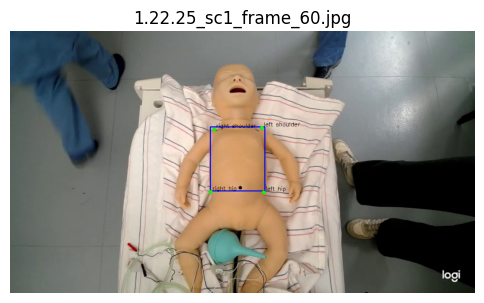

🔍 Predicting: 1.22.25_sc2_frame_181.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/1.22.25_sc2_frame_181.jpg: 384x640 1 torso, 43.5ms
Speed: 2.3ms preprocess, 43.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


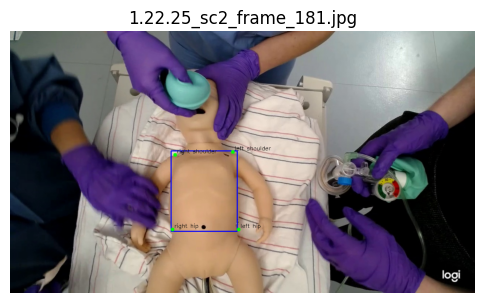

🔍 Predicting: 1.22.25_sc2_frame_194.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/1.22.25_sc2_frame_194.jpg: 384x640 1 torso, 41.4ms
Speed: 1.8ms preprocess, 41.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


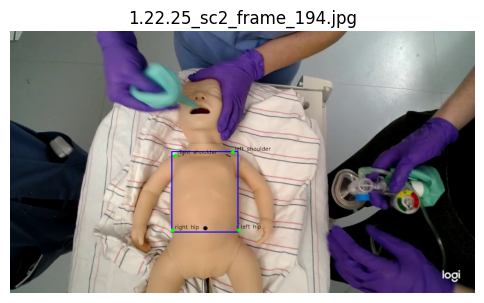

🔍 Predicting: 1.22.25_sc3_frame_168.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/1.22.25_sc3_frame_168.jpg: 384x640 1 torso, 49.8ms
Speed: 1.8ms preprocess, 49.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


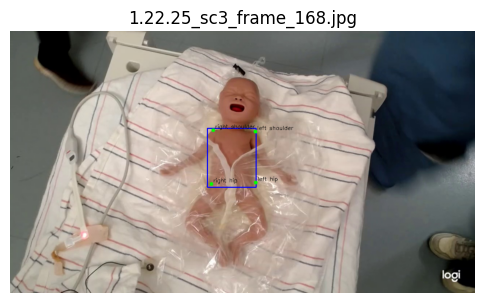

🔍 Predicting: 1.22.25_sc4_frame_115.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/1.22.25_sc4_frame_115.jpg: 384x640 1 torso, 50.0ms
Speed: 1.7ms preprocess, 50.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


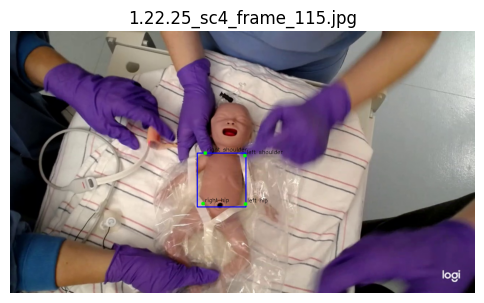

🔍 Predicting: 1.22.25_sc4_frame_153.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/1.22.25_sc4_frame_153.jpg: 384x640 1 torso, 45.4ms
Speed: 2.0ms preprocess, 45.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


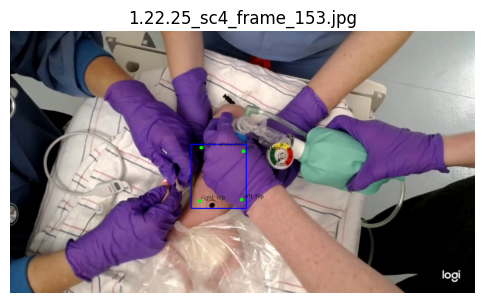

🔍 Predicting: 1.22.25_sc6_frame_247.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/1.22.25_sc6_frame_247.jpg: 384x640 1 torso, 40.9ms
Speed: 1.7ms preprocess, 40.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


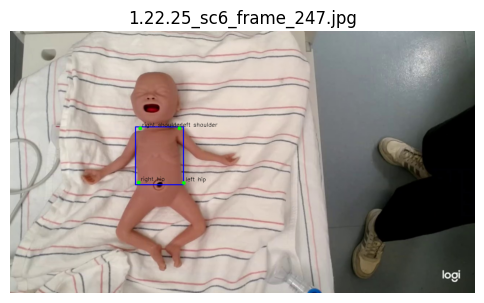

🔍 Predicting: 1.22.25_sc8_frame_161.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/1.22.25_sc8_frame_161.jpg: 384x640 1 torso, 44.6ms
Speed: 1.8ms preprocess, 44.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


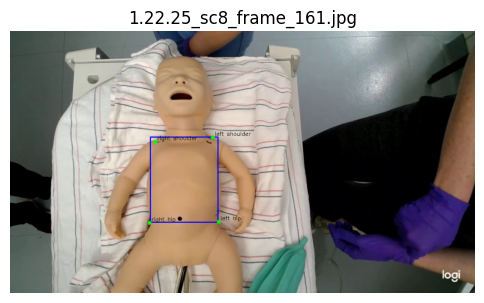

🔍 Predicting: 1.22.25_sc8_frame_52.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/1.22.25_sc8_frame_52.jpg: 384x640 1 torso, 44.2ms
Speed: 1.8ms preprocess, 44.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


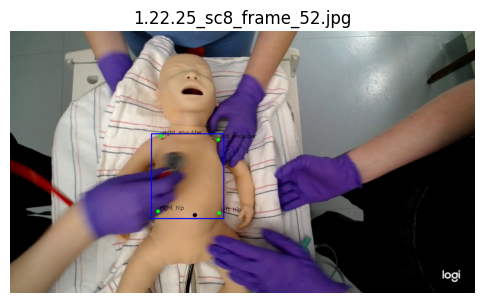

🔍 Predicting: 10_18sc1_frame_233.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/10_18sc1_frame_233.jpg: 384x640 (no detections), 45.2ms
Speed: 2.2ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


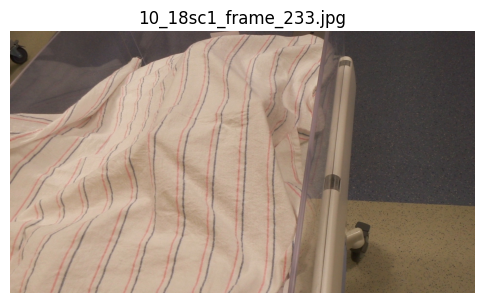

🔍 Predicting: 2.24.25_sc1_cropped_frame_248.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/2.24.25_sc1_cropped_frame_248.jpg: 384x640 1 torso, 42.0ms
Speed: 1.8ms preprocess, 42.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


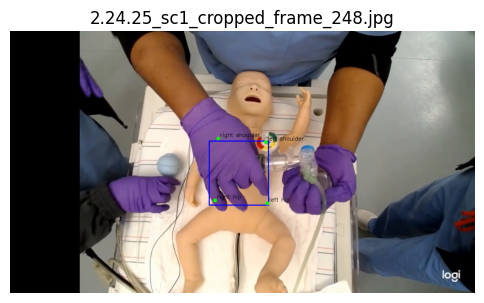

🔍 Predicting: 2.24.25_sc2_frame_240.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/2.24.25_sc2_frame_240.jpg: 384x640 1 torso, 42.2ms
Speed: 1.7ms preprocess, 42.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


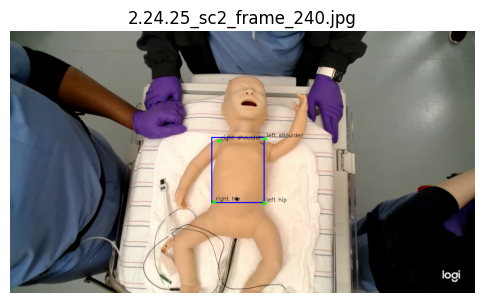

🔍 Predicting: 2.24.25_sc3_frame_206.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/2.24.25_sc3_frame_206.jpg: 384x640 1 torso, 45.5ms
Speed: 1.8ms preprocess, 45.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


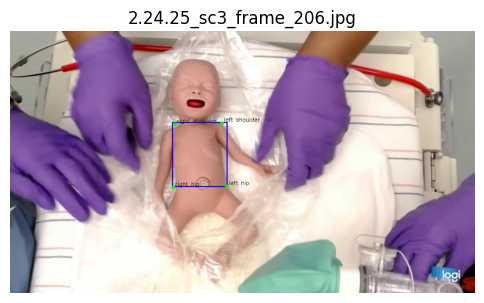

🔍 Predicting: 2.24.25_sc4_trimmed_frame_114.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/2.24.25_sc4_trimmed_frame_114.jpg: 384x640 1 torso, 41.8ms
Speed: 1.8ms preprocess, 41.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


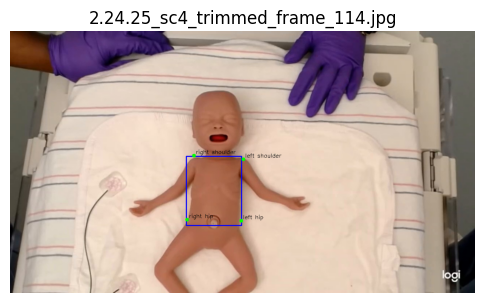

🔍 Predicting: 2.25.25_sc4_cropped_frame_29.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/2.25.25_sc4_cropped_frame_29.jpg: 384x640 1 torso, 40.9ms
Speed: 1.8ms preprocess, 40.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


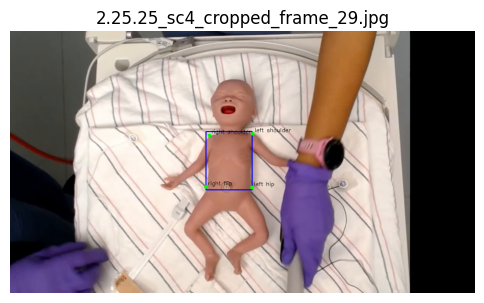

🔍 Predicting: 2.6.25_sc3_frame_80.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/2.6.25_sc3_frame_80.jpg: 384x640 1 torso, 45.2ms
Speed: 1.9ms preprocess, 45.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


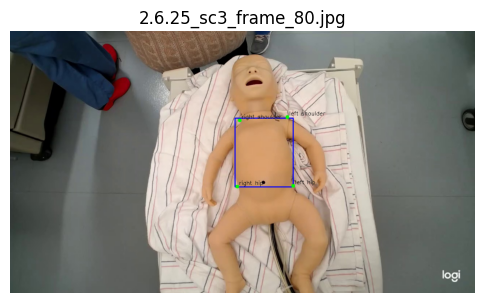

🔍 Predicting: 2.6.25_sc9_frame_10.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/2.6.25_sc9_frame_10.jpg: 384x640 1 torso, 44.5ms
Speed: 1.9ms preprocess, 44.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


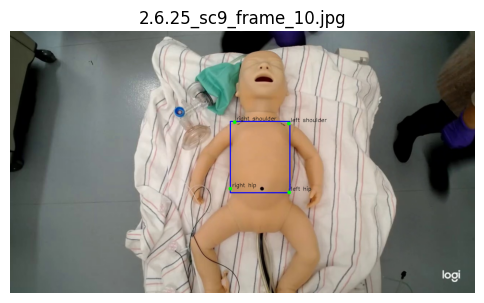

🔍 Predicting: 3.7.25_sc1_frame_164.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/3.7.25_sc1_frame_164.jpg: 384x640 1 torso, 41.3ms
Speed: 1.9ms preprocess, 41.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


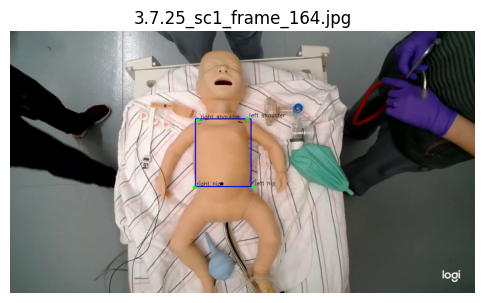

🔍 Predicting: 3.7.25_sc3_trimmed_frame_243.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/3.7.25_sc3_trimmed_frame_243.jpg: 384x640 1 torso, 40.5ms
Speed: 1.9ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


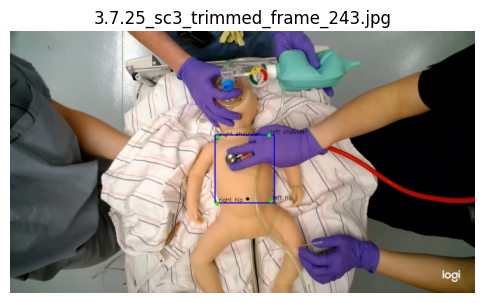

🔍 Predicting: 3.7.25_sc6_frame_32.jpg

image 1/1 /content/drive/My Drive/6.7930/torso_dataset/images/val/3.7.25_sc6_frame_32.jpg: 384x640 1 torso, 48.6ms
Speed: 2.3ms preprocess, 48.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


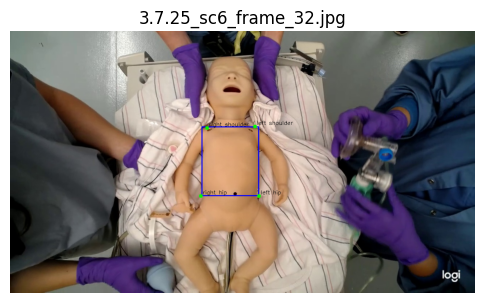

In [37]:
display_all_val_predictions(
    model=trained_model,
    base_path=base_path,
    keypoint_labels=["left shoulder", "right shoulder", "left hip", "right hip"],
    conf_thresh=0.5,
    #max_images=10  # Optional: only show first 10
)

#Model Inference on Video

In [60]:
import os
import glob
import shutil
from ultralytics import YOLO

def track_all_videos_in_folder(model, video_folder, tracker="botsort.yaml", conf=0.25, imgsz=640, device="0"):
    """
    Runs YOLO pose tracking on all videos in a folder and saves results into a subfolder.

    Args:
        model (YOLO): Loaded YOLOv8 model (e.g., YOLO("best.pt"))
        video_folder (str): Path to the folder containing input videos
        tracker (str): Tracker type (default: "botsort.yaml")
        conf (float): Confidence threshold
        imgsz (int): Image size for inference
        device (str): Device to use ("cpu" or GPU index like "0")
    """
    # Create output folder inside input folder
    output_folder = os.path.join(video_folder, "tracked_predictions")
    os.makedirs(output_folder, exist_ok=True)

    # Support multiple video formats
    video_extensions = ("*.mp4", "*.mov")
    video_paths = []
    for ext in video_extensions:
        video_paths.extend(glob.glob(os.path.join(video_folder, ext)))
    video_paths = sorted(video_paths)

    if not video_paths:
        print("❌ No supported video files found in folder.")
        return

    for video_path in video_paths:
        video_name = os.path.basename(video_path)
        print(f"\n📹 Tracking: {video_name}")

        results = model.track(
            source=video_path,
            conf=conf,
            imgsz=imgsz,
            save=True,
            device=device,
            tracker=tracker,
            max_det=1,  # Only detect 1 object per frame
        )

        # YOLO pose tracking saves to: runs/pose/predict/video_name.avi
        save_dir = results[0].save_dir  # e.g., PosixPath('runs/pose/predict')
        predicted_file = os.path.join(save_dir, os.path.splitext(video_name)[0] + ".avi")
        output_path = os.path.join(output_folder, os.path.basename(predicted_file))

        print(f"📁 Predicted output: {predicted_file}")

        if os.path.exists(predicted_file):
            shutil.copy2(predicted_file, output_path)
            print(f"✅ Saved to: {output_path}")
        else:
            print(f"⚠️ Output not found — skipping {video_name}")


In [51]:
track_all_videos_in_folder(
    model=trained_model,
    video_folder="/content/drive/MyDrive/6.7930/test_video_clips",
    tracker="botsort.yaml",
    conf=0.5,
    imgsz=640,
    device="0"
)

Streaming output truncated to the last 5000 lines.
video 1/1 (frame 1039/2393) /content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov: 384x640 (no detections), 43.9ms
video 1/1 (frame 1040/2393) /content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov: 384x640 (no detections), 45.2ms
video 1/1 (frame 1041/2393) /content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov: 384x640 (no detections), 40.4ms
video 1/1 (frame 1042/2393) /content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov: 384x640 (no detections), 42.0ms
video 1/1 (frame 1043/2393) /content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov: 384x640 (no detections), 44.7ms
video 1/1 (frame 1044/2393) /content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov: 384x640 (no detections), 45.0ms
video 1/1 (frame 1045/2393) /content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov: 384x640 (no det

In [52]:
def track_single_video_to_output(model, input_video_path, output_dir, tracker="botsort.yaml", conf=0.25, imgsz=640, device="0"):
    """
    Tracks a single video using YOLO pose model and saves result to the specified output folder.

    Args:
        model (YOLO): Trained YOLO model (e.g., YOLO("best.pt"))
        input_video_path (str): Path to the input video file
        output_dir (str): Directory to save the output tracked video
        tracker (str): Tracker type (default: "botsort.yaml")
        conf (float): Confidence threshold
        imgsz (int): Inference image size
        device (str): Device to use (e.g., "0", "cpu")
    """
    video_name = os.path.basename(input_video_path)
    print(f"\n📹 Tracking single video: {video_name}")

    results = model.track(
        source=input_video_path,
        conf=conf,
        imgsz=imgsz,
        save=True,
        device=device,
        tracker=tracker
    )

    save_dir = results[0].save_dir  # e.g., runs/pose/predict
    predicted_file = os.path.join(save_dir, os.path.splitext(video_name)[0] + ".avi")
    output_path = os.path.join(output_dir, os.path.basename(predicted_file))

    os.makedirs(output_dir, exist_ok=True)
    print(f"📁 Predicted output: {predicted_file}")

    if os.path.exists(predicted_file):
        shutil.copy2(predicted_file, output_path)
        print(f"✅ Saved to: {output_path}")
    else:
        print(f"⚠️ Output not found — skipping {video_name}")


In [54]:
doesPathExists("/content/drive/Mydrive/6.7930/test_video_clips/tracked_prediction_angled_videos")

❌ Path does not exist!


In [61]:
track_single_video_to_output(
    model=trained_model,
    input_video_path="/content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov",
    output_dir="/content/drive/MyDrive/6.7930/test_video_clips/tracked_prediction_angled_videos",
    tracker="botsort.yaml",
    conf=0.3, # reduce conf threshold for weirdly POV video
    imgsz=640,
    device="0"
)


📹 Tracking single video: 11_11sc2blurred_shortened.mov


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/2393) /content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov: 384x640 (no detections), 46.0ms
video 1/1 (frame 2/2393) /content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov: 384x640 (no detections), 40.8ms
video 1/1 (frame 3/2393) /content/drive/MyDrive/6.7930/test_video_clips/11_11sc2blurred_shortened.mov: 384x640 (no detections), 40